# Boxplot of top five up- and downregulated genes

In [1]:
library(ggpubr)
library(ggsignif)
library(tidyverse)

Loading required package: ggplot2

-- Attaching packages --------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ------------------------------------------------------------------------------------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Functions

In [2]:
add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
    as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
    dplyr::ungroup() %>%
    mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## All genes

### Differential expressed genes

In [3]:
genes = read.delim('../../_m/genes/diffExpr_EAvsAA_full.txt')
genes = genes %>% filter(adj.P.Val < 0.05) %>%  
            select(gencodeID, ensemblID, Symbol, logFC, t, adj.P.Val)
genes = add_symnum(genes)

up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Up') %>% head(5) 
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Down') %>% head(5) 

sig_genes = bind_rows(up_genes, down_genes) %>% 
    mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

gencodeID,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>
ENSG00000147403.16,ENSG00000147403,RPL10,0.4171757,17.13536,4.899139e-44,< 2e-16,****,Up,RPL10
ENSG00000215374.5,ENSG00000215374,FAM66B,1.1781795,14.75959,6.324136e-35,< 2e-16,****,Up,FAM66B
ENSG00000272977.1,ENSG00000272977,,2.1912977,14.69538,9.448099e-35,< 2e-16,****,Up,ENSG00000272977
ENSG00000196312.12,ENSG00000196312,MFSD14C,0.4036692,14.17251,9.191264e-33,< 2e-16,****,Up,MFSD14C
ENSG00000107951.13,ENSG00000107951,MTPAP,0.2483120,13.81096,1.836861e-31,< 2e-16,****,Up,MTPAP
ENSG00000233913.7,ENSG00000233913,,-2.9235140,-17.57127,1.695851e-45,< 2e-16,****,Down,ENSG00000233913
ENSG00000230076.1,ENSG00000230076,,-5.2611148,-16.66051,2.687357e-42,< 2e-16,****,Down,ENSG00000230076
ENSG00000204894.4,ENSG00000204894,,-4.4224774,-16.17919,1.738051e-40,< 2e-16,****,Down,ENSG00000204894
ENSG00000226278.1,ENSG00000226278,PSPHP1,-5.7468390,-13.97893,4.586021e-32,< 2e-16,****,Down,PSPHP1


### Load residualized expression

In [4]:
res_file = '../../_m/genes/residualized_expression.tsv'
tmp_df = data.table::fread(res_file, data.table=F)

resdf0 = tmp_df %>% filter(V1 %in% sig_genes$gencodeID) %>%
    column_to_rownames("V1")
resdf0 <- data.frame(t(resdf0))
resdf0[1:2, 1:5]

Warning message in data.table::fread(res_file, data.table = F):
"Detected 359 column names but the data has 360 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,ENSG00000230076.1,ENSG00000233913.7,ENSG00000226278.1,ENSG00000204894.4,ENSG00000215374.5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R10424,-1.1914188,-2.2304033,-1.4007203,-1.406353,-0.7208750
R12195,-0.6856922,-0.7878148,0.9499562,1.195285,0.3563796


### Load pheno data

In [5]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/dlpfc_phenotypes.csv'
pheno = read.csv(pheno_file, row.names=1) %>% mutate_if(is.character, as.factor)
levels(pheno$Race) <- c("AA", "AS", "EA", "HISP")
head(pheno, 2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
R10424,Br5168,R10424,DLPFC,6.7,64.08,M,EA,Control
R12195,Br5073,R12195,DLPFC,8.4,62.61,M,AA,Schizo


### Merge dataframe

In [7]:
resdf <- inner_join(rownames_to_column(pheno), 
                    rownames_to_column(resdf0), 
                    by="rowname")
dim(resdf)
resdf[1:2, 1:10]

[1] 360  19

,rowname,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx,ENSG00000084628.9
,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>
1,R10424,Br5168,R10424,DLPFC,6.7,64.08,M,EA,Control,0.53663440
2,R12195,Br5073,R12195,DLPFC,8.4,62.61,M,AA,Schizo,-0.09328164


### Melt data frame

In [11]:
df = resdf %>% select(c('rowname', 'Race', starts_with('ENSG'))) %>%
    pivot_longer(-c(rowname, Race), names_to = "gencodeID", values_to = "Res") %>%
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "gencodeID"), as.factor)

df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
df$Race <- fct_drop(df$Race)
head(df, 2)

Warning message:
"Column `gencodeID` joining character vector and factor, coercing into character vector"


rowname,Race,gencodeID,Res,ensemblID,Symbol,logFC,t,adj.P.Val,FDR,p.signif,Direction,New_ID
<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
R10424,EA,ENSG00000084628.9,0.5366344,ENSG00000084628,NKAIN1,0.6275692,11.36025,2.413823e-22,< 2e-16,****,Up,NKAIN1
R10424,EA,ENSG00000230076.1,-1.5494870,ENSG00000230076,,-3.9102589,-14.26303,6.025320e-33,< 2e-16,****,Down,ENSG00000230076


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


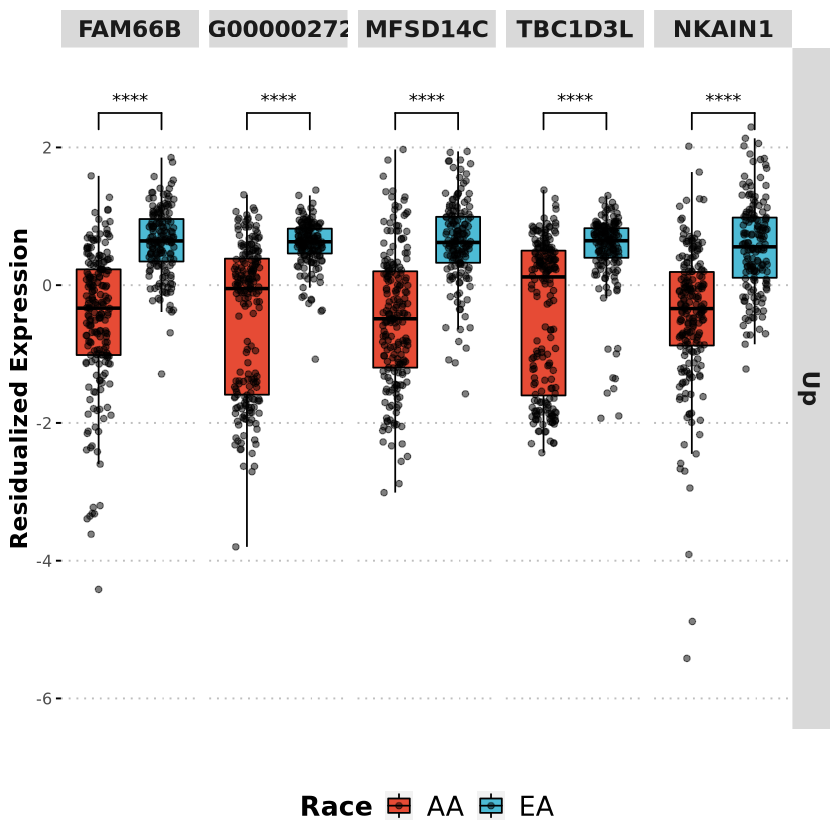

In [17]:
tmp = sig_genes %>% mutate(group1='AA', group2='EA', y_pos=2.5) %>% 
    filter(Direction == 'Up') %>% 
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Up") %>% 
    ggboxplot(x="Race", y="Res", facet.by=c("Direction", "New_ID"), palette="npg",
              panel.labs.font=list(face='bold', size = 14), fill="Race", xlab='', 
              outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
              add.params=list(alpha=0.5), legend="bottom", ylim=c(-6, 3), 
              ggtheme=theme_pubclean()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, 
                    y_position=y_pos), 
                manual=TRUE) + 
    font("xy.title", size=14, face="bold") + 
    font("legend.title", size=16, face="bold") + 
    font("legend.text", size=16) + rremove("x.text") + rremove("x.ticks")
         
bxp_up

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


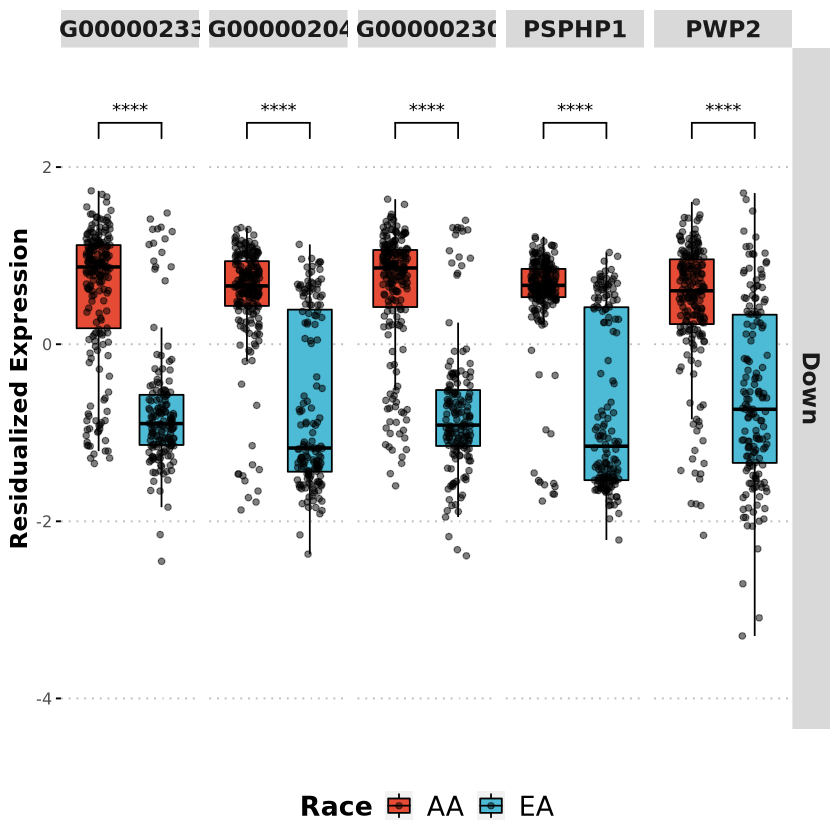

In [23]:
tmp = sig_genes %>% mutate(group1='AA', group2='EA', y_pos=2.5) %>% 
    filter(Direction == 'Down') %>% 
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Down") %>% 
    ggboxplot(x="Race", y="Res", fill="Race", facet.by=c("Direction", "New_ID"), 
              panel.labs.font=list(face='bold', size = 14), palette="npg", xlab='', 
              outlier.shape=NA, ylab='Residualized Expression', add='jitter', 
              add.params=list(alpha=0.5), legend="bottom", ylim=c(-4, 3), 
              ggtheme=theme_pubclean()) +
    geom_signif(data=tmp, 
                aes(xmin=group1, xmax=group2, annotations=p.signif, 
                    y_position=y_pos), 
                manual=TRUE) + 
    font("xy.title", size=14, face="bold") + 
    font("legend.title", size=16, face="bold") + 
    font("legend.text", size=16) + rremove("x.text") + rremove("x.ticks")
         
bxp_down

### Annotate figure

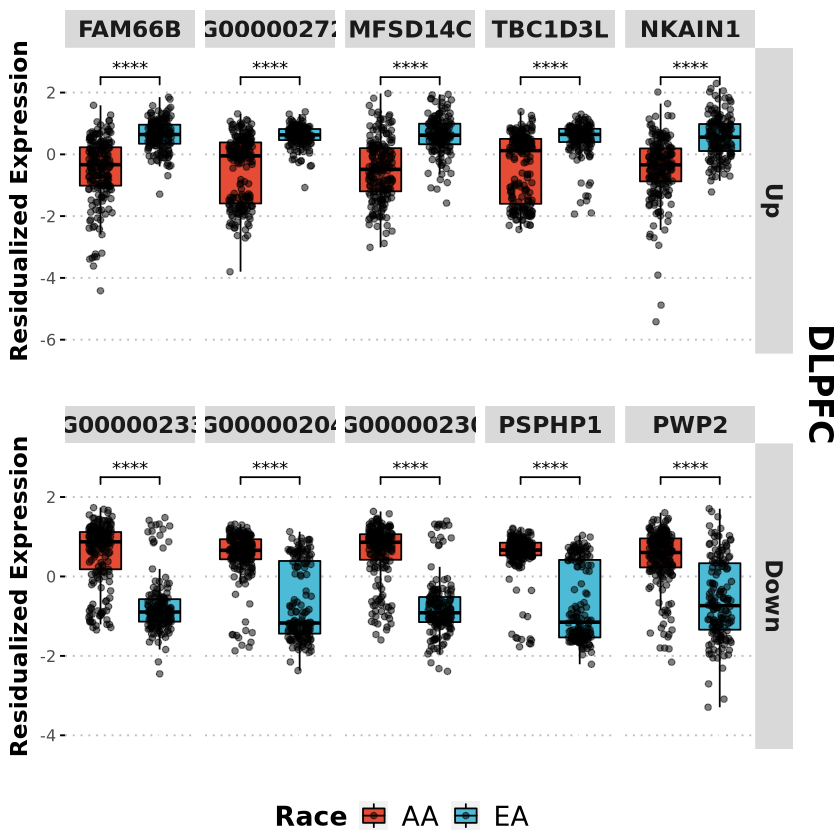

In [26]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow = 2, 
                    common.legend=TRUE, legend="bottom")
figure <- annotate_figure(figure, right=text_grob("DLPFC", size=20, rot=-90, 
                                                  face='bold', hjust=0.8))
figure

In [25]:
save_ggplots('dlpfc_topSig_boxplot', figure, 12, 9)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()